# Line Data

In [3]:
import json
import numpy as np
from opendssdirect import dss
import os
import logging

class LineDataGeneration:
    def __init__(self, dss_file, output_dir="results", print_data=False):
        self.dss_file = dss_file
        self.output_dir = output_dir
        self.line_data = {}
        self.print_data = print_data
        os.makedirs(self.output_dir, exist_ok=True)
        logging.basicConfig(filename=os.path.join(self.output_dir, 'log.txt'), level=logging.INFO)

    def load_system(self):
        """Loads the DSS file and solves the power flow."""
        try:
            dss.run_command(f'Redirect "{self.dss_file}"')
            if dss.Circuit.Name() == "":
                raise Exception("Failed to create a circuit. Check the DSS file.")
            dss.Solution.Solve()
            if dss.Solution.Converged():
                logging.info(f'Successfully loaded and solved DSS file: {self.dss_file}')
            else:
                raise Exception("DSS solution did not converge.")
        except Exception as e:
            logging.error(f'Error loading DSS file: {e}')
            raise

    def extract_line_data(self):
        """Extracts line data from the DSS file and stores it in a structured format."""
        try:
            df = dss.utils.lines_to_dataframe()
            for _, row in df.iterrows():
                line = row['Name']
                length = row['Length']
                phases = row['Phases']
                
                if phases == 3:
                    bus1_phases = row['Bus1'].split('.')[1:] or ['1', '2', '3']
                    bus2_phases = row['Bus2'].split('.')[1:] or ['1', '2', '3']
                else:
                    bus1_phases = row['Bus1'].split('.')[1:]
                    bus2_phases = row['Bus2'].split('.')[1:]

                r_matrix = np.array(row['RMatrix']).reshape((phases, phases)) * length
                x_matrix = np.array(row['XMatrix']).reshape((phases, phases)) * length

                self.line_data[line] = {
                    'RMatrix': r_matrix.tolist(),
                    'XMatrix': x_matrix.tolist(),
                    'Length': length,
                    'Units': row['Units'],
                    'Phases': phases,
                    'FromBus': row['Bus1'].split('.')[0],
                    'ToBus': row['Bus2'].split('.')[0],
                    'Bus1Phases': bus1_phases,
                    'Bus2Phases': bus2_phases
                }

            # Include transformer xfm1 as a line
            for trans in dss.Transformers.AllNames():
                dss.Transformers.Name(trans)
                if trans == 'xfm1':
                    bus1 = '709'  # Primary bus for IEEE 37 Bus
                    bus2 = '775'  # Secondary bus for IEEE 37 Bus
                    resistance = dss.Transformers.R() * 0.01  # Resistance
                    reactance = dss.Transformers.Xhl() * 0.01  # Reactance
                    phases = 3  # Assuming a 3-phase transformer
                    length = 1  # Length is 1 for transformer equivalent line

                    r_matrix = np.array([[resistance, 0, 0], [0, resistance, 0], [0, 0, resistance]])
                    x_matrix = np.array([[reactance, 0, 0], [0, reactance, 0], [0, 0, reactance]])

                    self.line_data['xfm1'] = {
                        'RMatrix': r_matrix.tolist(),
                        'XMatrix': x_matrix.tolist(),
                        'Length': length,
                        'Units': 'none',
                        'Phases': phases,
                        'FromBus': bus1,
                        'ToBus': bus2,
                        'Bus1Phases': ['1', '2', '3'],
                        'Bus2Phases': ['1', '2', '3']
                    }

            logging.info('Successfully extracted and adjusted line data')
            if self.print_data:
                self.print_line_data()
        except Exception as e:
            logging.error(f'Error extracting line data: {e}')
            raise

    def save_line_data(self, test_case=""):
        """Saves the extracted line data to the output directory."""
        try:
            with open(os.path.join(self.output_dir, f"{test_case}_line_data.json"), "w") as f:
                json.dump(self.line_data, f, indent=4)
            logging.info(f'Line data saved to {self.output_dir} as {test_case}')
        except Exception as e:
            logging.error(f'Error saving line data: {e}')
            raise

    def print_line_data(self):
        """Prints the extracted line data."""
        for line, data in self.line_data.items():
            print(f"Line: {line}")
            print(f"FromBus: {data['FromBus']}")
            print(f"ToBus: {data['ToBus']}")
            print(f"Phases: {data['Phases']}")
            print(f"Bus1Phases: {data['Bus1Phases']}")
            print(f"Bus2Phases: {data['Bus2Phases']}")
            print(f"RMatrix:\n{np.array(data['RMatrix'])}")
            print(f"XMatrix:\n{np.array(data['XMatrix'])}")
            print(f"Length: {data['Length']}")
            print(f"Units: {data['Units']}")
            print()

class PerUnitConverter:
    def __init__(self, input_file, output_file, base_power):
        self.input_file = input_file
        self.output_file = output_file
        self.base_power = base_power
        self.line_data = {}
        self.line_data_pu = {}

    def load_line_data(self):
        """Loads the line data from the specified input file."""
        try:
            with open(self.input_file, "r") as f:
                self.line_data = json.load(f)
            print("Successfully loaded line data")
        except Exception as e:
            print(f"Error loading line data: {e}")
            raise

    def get_bus_base_voltage(self, bus_name, phases):
        """Gets the base voltage of the specified bus."""
        dss.Circuit.SetActiveBus(bus_name)
        v_base_phase = dss.Bus.kVBase() * 1e3  # Convert kV to V
        v_base_line_to_line = v_base_phase * np.sqrt(3) if phases > 0 else v_base_phase
        return v_base_line_to_line

    def convert_to_per_unit(self):
        """Converts the line data to per unit values."""
        try:
            for line, data in self.line_data.items():
                from_bus = data['FromBus']
                phases = data['Phases']

                # Get base voltage for from_bus
                v_base = self.get_bus_base_voltage(from_bus, phases)
                z_base = (v_base ** 2) / self.base_power

                r_matrix = np.array(data['RMatrix'])
                x_matrix = np.array(data['XMatrix'])

                r_matrix_pu = r_matrix / z_base
                x_matrix_pu = x_matrix / z_base

                self.line_data_pu[line] = {
                    'RMatrix_pu': r_matrix_pu.tolist(),
                    'XMatrix_pu': x_matrix_pu.tolist(),
                    'Length': data['Length'],
                    'Units': data['Units'],
                    'Phases': data['Phases'],
                    'FromBus': from_bus,
                    'ToBus': data['ToBus'],
                    'Bus1Phases': data['Bus1Phases'],
                    'Bus2Phases': data['Bus2Phases'],
                    'VBase': v_base,
                    'ZBase': z_base
                }

            print("Successfully converted line data to per unit")
        except Exception as e:
            print(f"Error converting line data to per unit: {e}")
            raise

    def save_per_unit_data(self, test_case=""):
        """Saves the per unit line data to the specified output file."""
        try:
            with open(self.output_file, "w") as f:
                json.dump(self.line_data_pu, f, indent=4)
            print(f"Per unit line data saved to {self.output_file}")
        except Exception as e:
            print(f"Error saving per unit line data: {e}")
            raise

    def print_per_unit_data(self):
        """Prints the per unit line data."""
        for line, data in self.line_data_pu.items():
            print(f"Line: {line}")
            print(f"FromBus: {data['FromBus']}")
            print(f"ToBus: {data['ToBus']}")
            print(f"Phases: {data['Phases']}")
            print(f"Bus1Phases: {data['Bus1Phases']}")
            print(f"Bus2Phases: {data['Bus2Phases']}")
            print(f"RMatrix (p.u.):\n{np.array(data['RMatrix_pu'])}")
            print(f"XMatrix (p.u.):\n{np.array(data['XMatrix_pu'])}")
            print(f"Length: {data['Length']}")
            print(f"Units: {data['Units']}")
            print(f"VBase (V): {data['VBase']}")
            print(f"ZBase (Ohm): {data['ZBase']}\n")

if __name__ == "__main__":
    try:
        # TestCase options
        # Uncomment the desired test case
        # test_case = '13Bus'
        # dss_file = "/Users/babaktaheri/Desktop/OLDF/Multi-phase/data/IEEETestCases/13Bus/IEEE13Nodeckt.dss"
        
        test_case = '37Bus'
        dss_file = "/Users/babaktaheri/Desktop/OLDF/Multi-phase/data/IEEETestCases/37Bus/ieee37.dss"
        
        # Part 1: Line Scenario Generation
        simulator = LineDataGeneration(dss_file, print_data=True)
        simulator.load_system()
        simulator.extract_line_data()
        simulator.save_line_data(test_case=test_case)

        # Part 2: Per Unit Conversion
        base_power = 500e3  # Base power in VA
        input_file = f"results/{test_case}_line_data.json"
        output_file = f"results/{test_case}_line_data_pu.json"

        converter = PerUnitConverter(input_file, output_file, base_power)
        converter.load_line_data()
        converter.convert_to_per_unit()
        converter.save_per_unit_data(test_case=test_case)
        converter.print_per_unit_data()

        print("Line data extraction and saving completed successfully.")
    except Exception as e:
        logging.error(f'Error in main execution: {e}')
        print(f'Error in main execution: {e}')


Line: l0
FromBus: 799r
ToBus: 701
Phases: 3
Bus1Phases: ['1', '2', '3']
Bus2Phases: ['1', '2', '3']
RMatrix:
[[0.10252083 0.02358049 0.01180777]
 [0.02358049 0.09271023 0.02358049]
 [0.01180777 0.02358049 0.10252083]]
XMatrix:
[[ 0.06912973 -0.01289394 -0.01461079]
 [-0.01289394  0.06657197 -0.01289394]
 [-0.01461079 -0.01289394  0.06912973]]
Length: 1.85
Units: 0

Line: l1
FromBus: 701
ToBus: 702
Phases: 3
Bus1Phases: ['1', '2', '3']
Bus2Phases: ['1', '2', '3']
RMatrix:
[[0.08638182 0.02961818 0.02243636]
 [0.02961818 0.0816     0.02961818]
 [0.02243636 0.02961818 0.08638182]]
XMatrix:
[[ 0.05405455 -0.00592727 -0.01103636]
 [-0.00592727  0.04869091 -0.00592727]
 [-0.01103636 -0.00592727  0.05405455]]
Length: 0.96
Units: 0

Line: l2
FromBus: 702
ToBus: 705
Phases: 3
Bus1Phases: ['1', '2', '3']
Bus2Phases: ['1', '2', '3']
RMatrix:
[[0.15872727 0.03942424 0.03731818]
 [0.03942424 0.15960606 0.03942424]
 [0.03731818 0.03942424 0.15872727]]
XMatrix:
[[0.05877273 0.02074242 0.01608333]
 [0

# H_P and H_Q Matrices

In [4]:
import numpy as np
import json
import os
import logging

class HMatrixCalculation:
    def __init__(self, input_dir="results", test_case="", print_data=False):
        self.input_dir = input_dir
        self.test_case = test_case
        self.line_data = {}
        self.h_matrices = {}
        self.block_diagonal_matrix_hp = None
        self.block_diagonal_matrix_hq = None
        self.print_data = print_data
        logging.basicConfig(filename=os.path.join(self.input_dir, f'{test_case}_log.txt'), level=logging.INFO)

    def load_line_data(self):
        """Loads the line data from the specified input file."""
        try:
            with open(os.path.join(self.input_dir, f"{self.test_case}_line_data_pu.json"), "r") as f:
                self.line_data = json.load(f)
            logging.info('Successfully loaded line data')
            if self.print_data:
                self.print_line_data()
        except Exception as e:
            logging.error(f'Error loading line data: {e}')
            raise

    def calculate_h_matrices(self):
        """Calculates the H matrices from the line data."""
        try:
            for line, data in self.line_data.items():
                r_matrix = np.array(data['RMatrix_pu'])
                x_matrix = np.array(data['XMatrix_pu'])
                bus1_phases = data['Bus1Phases']

                # Create a dictionary to map each phase to its corresponding index in a 3x3 matrix
                phase_to_index = {phase: int(phase) - 1 for phase in bus1_phases}

                # Initialize the 3x3 H matrices with zeros
                H_P = np.zeros((3, 3))
                H_Q = np.zeros((3, 3))

                # Iterate through the available phases and populate the H matrices accordingly
                for i, phase_i in enumerate(bus1_phases):
                    i_index = phase_to_index[phase_i]  # Index in the H matrix based on the actual phase
                    for j, phase_j in enumerate(bus1_phases):
                        j_index = phase_to_index[phase_j]  # Same logic for column index

                        if i_index == j_index:
                            H_P[i_index, j_index] = -2 * r_matrix[i][j]  # Accessing using available phase indices
                            H_Q[i_index, j_index] = -2 * x_matrix[i][j]
                        else:
                            if (i_index, j_index) in [(0, 1), (1, 2), (2, 0)]:
                                sign = -1
                            else:
                                sign = 1

                            H_P[i_index, j_index] = r_matrix[i][j] + sign * np.sqrt(3) * x_matrix[i][j]
                            H_Q[i_index, j_index] = x_matrix[i][j] - sign * np.sqrt(3) * r_matrix[i][j]

                self.h_matrices[line] = {
                    'H_P': H_P.tolist(),
                    'H_Q': H_Q.tolist(),
                    'FromBus': data['FromBus'],
                    'ToBus': data['ToBus'],
                    'Phases': len(bus1_phases)
                }

            logging.info('Successfully calculated H matrices')
            if self.print_data:
                self.print_h_matrices()
        except Exception as e:
            logging.error(f'Error calculating H matrices: {e}')
            raise

    def create_block_diagonal_matrices(self):
        """Creates block diagonal matrices from the H matrices."""
        try:
            num_lines = len(self.h_matrices)
            block_size = 3
            total_size = num_lines * block_size
            self.block_diagonal_matrix_hp = np.zeros((total_size, total_size))
            self.block_diagonal_matrix_hq = np.zeros((total_size, total_size))

            for i, (line, matrices) in enumerate(self.h_matrices.items()):
                H_P = np.array(matrices['H_P'])
                H_Q = np.array(matrices['H_Q'])
                start_index = i * block_size
                self.block_diagonal_matrix_hp[start_index:start_index+block_size, start_index:start_index+block_size] = H_P
                self.block_diagonal_matrix_hq[start_index:start_index+block_size, start_index:start_index+block_size] = H_Q

            logging.info('Successfully created block diagonal matrices')
            if self.print_data:
                self.print_block_diagonal_matrices()
        except Exception as e:
            logging.error(f'Error creating block diagonal matrices: {e}')
            raise

    def print_line_data(self):
        """Prints the loaded line data."""
        for line, data in self.line_data.items():
            print(f"Line: {line}, FromBus: {data['FromBus']}, ToBus: {data['ToBus']}, Phases: {data['Phases']}")
            print(f"RMatrix:\n{np.array(data['RMatrix_pu'])}")
            print(f"XMatrix:\n{np.array(data['XMatrix_pu'])}")

    def print_h_matrices(self):
        """Prints the calculated H matrices."""
        for line, matrices in self.h_matrices.items():
            print(f"Line: {line}, FromBus: {matrices['FromBus']}, ToBus: {matrices['ToBus']}")
            print(f"H_P:\n{np.array(matrices['H_P'])}")
            print(f"H_Q:\n{np.array(matrices['H_Q'])}")

    def print_block_diagonal_matrices(self):
        """Prints the block diagonal matrices."""
        print("Block Diagonal Matrix H_P:")
        print(self.block_diagonal_matrix_hp)
        print("Block Diagonal Matrix H_Q:")
        print(self.block_diagonal_matrix_hq)

    def save_h_matrices(self):
        """Saves the calculated H matrices to a JSON file."""
        try:
            with open(os.path.join(self.input_dir, f"{self.test_case}_h_matrices.json"), "w") as f:
                json.dump(self.h_matrices, f, indent=4)
            logging.info(f'H matrices saved to {self.input_dir}')
        except Exception as e:
            logging.error(f'Error saving H matrices: {e}')
            raise

    def save_block_diagonal_matrices(self):
        """Saves the block diagonal matrices to Numpy files."""
        try:
            np.save(os.path.join(self.input_dir, f"{self.test_case}_block_diagonal_matrix_hp.npy"), self.block_diagonal_matrix_hp)
            np.save(os.path.join(self.input_dir, f"{self.test_case}_block_diagonal_matrix_hq.npy"), self.block_diagonal_matrix_hq)
            logging.info('Block diagonal matrices saved')
        except Exception as e:
            logging.error(f'Error saving block diagonal matrices: {e}')
            raise

if __name__ == "__main__":
    # TestCase options
    # Uncomment the desired test case
    # test_case = '13Bus'
    # test_case = '37Bus'
    test_case = '37Bus'  # Change to '13Bus' if needed

    calculator = HMatrixCalculation(test_case=test_case, print_data=True)
    calculator.load_line_data()
    calculator.calculate_h_matrices()
    calculator.create_block_diagonal_matrices()
    calculator.save_h_matrices()
    calculator.save_block_diagonal_matrices()


Line: l0, FromBus: 799r, ToBus: 701, Phases: 3
RMatrix:
[[0.00222484 0.00051173 0.00025624]
 [0.00051173 0.00201194 0.00051173]
 [0.00025624 0.00051173 0.00222484]]
XMatrix:
[[ 0.00150021 -0.00027982 -0.00031707]
 [-0.00027982  0.0014447  -0.00027982]
 [-0.00031707 -0.00027982  0.00150021]]
Line: l1, FromBus: 701, ToBus: 702, Phases: 3
RMatrix:
[[0.00187461 0.00064276 0.0004869 ]
 [0.00064276 0.00177083 0.00064276]
 [0.0004869  0.00064276 0.00187461]]
XMatrix:
[[ 0.00117306 -0.00012863 -0.0002395 ]
 [-0.00012863  0.00105666 -0.00012863]
 [-0.0002395  -0.00012863  0.00117306]]
Line: l2, FromBus: 702, ToBus: 705, Phases: 3
RMatrix:
[[0.0034446  0.00085556 0.00080986]
 [0.00085556 0.00346367 0.00085556]
 [0.00080986 0.00085556 0.0034446 ]]
XMatrix:
[[0.00127545 0.00045014 0.00034903]
 [0.00045014 0.00121626 0.00045014]
 [0.00034903 0.00045014 0.00127545]]
Line: l3, FromBus: 702, ToBus: 713, Phases: 3
RMatrix:
[[0.00191406 0.00072073 0.00067842]
 [0.00072073 0.00192679 0.00072073]
 [0.0006

# Load Data- Using Line data to create buses to include the load transformers

In [6]:
import numpy as np
from opendssdirect import dss
import os
import json
import logging

class LoadScenarioGeneration:
    def __init__(self, dss_file, output_dir="results", S_base=500.0):
        self.dss_file = dss_file
        self.output_dir = output_dir
        self.S_base = S_base  # System base power in kVA (500 kVA)
        self.load_data = []
        self.bus_index = {}
        self.reference_bus = None
        os.makedirs(self.output_dir, exist_ok=True)
        logging.basicConfig(filename=os.path.join(self.output_dir, 'log.txt'), level=logging.INFO)

    def load_system(self):
        """Loads the DSS file and solves the power flow."""
        try:
            dss.run_command(f'Redirect "{self.dss_file}"')
            dss.Solution.Solve()
            logging.info(f'Successfully loaded and solved DSS file: {self.dss_file}')
        except Exception as e:
            logging.error(f'Error loading DSS file: {e}')
            raise

    def load_line_data(self, line_data_file):
        """Loads line data from a JSON file."""
        try:
            with open(line_data_file, "r") as f:
                self.line_data = json.load(f)
            logging.info(f'Successfully loaded line data from {line_data_file}')
        except Exception as e:
            logging.error(f'Error loading line data: {e}')
            raise

    def generate_bus_index_from_lines(self):
        """Generates an index for buses based on line data."""
        try:
            buses = []
            seen_buses = set()
            for line, data in self.line_data.items():
                bus1 = data['FromBus']
                bus2 = data['ToBus']
                if bus1 not in seen_buses:
                    buses.append(bus1)
                    seen_buses.add(bus1)
                if bus2 not in seen_buses:
                    buses.append(bus2)
                    seen_buses.add(bus2)

            self.bus_index = {bus: i for i, bus in enumerate(buses)}
            self.reference_bus = buses[0] if buses else None
            logging.info('Successfully generated bus index from line data')
        except Exception as e:
            logging.error(f'Error generating bus index from line data: {e}')
            raise

    def extract_load_data(self):
        """Extracts load data from the DSS file."""
        try:
            loads = dss.Loads.AllNames()
            for load in loads:
                dss.Loads.Name(load)
                bus = dss.CktElement.BusNames()[0].split('.')[0]
                phases = dss.Loads.Phases()
                conn = 'Delta' if dss.Loads.IsDelta() else 'Wye'
                P = dss.Loads.kW()
                Q = dss.Loads.kvar()
                kV = dss.Loads.kV()
                S = np.sqrt(P**2 + Q**2)
                power_factor = P / S if S != 0 else 0

                if bus in self.bus_index:
                    self.load_data.append({
                        'name': load,
                        'bus': bus,
                        'phases': phases,
                        'connection': conn,
                        'P': P,
                        'Q': Q,
                        'kV': kV,
                        'power_factor': power_factor,
                        'bus_full': dss.CktElement.BusNames()[0]
                    })
            logging.info('Successfully extracted load data')
        except Exception as e:
            logging.error(f'Error extracting load data: {e}')
            raise

    def organize_power_data(self):
        """Organizes the power data for each bus and phase."""
        try:
            P_bus_phase = {bus: np.zeros(3) for bus in self.bus_index}
            Q_bus_phase = {bus: np.zeros(3) for bus in self.bus_index}

            for load in self.load_data:
                bus = load['bus']
                bus_full = load['bus_full']
                P = load['P']
                Q = load['Q']
                connection = load['connection']
                phase_indices = [int(phase) - 1 for phase in bus_full.split('.')[1:]]

                if connection == 'Delta' and len(phase_indices) == 3:
                    for phase in phase_indices:
                        P_bus_phase[bus][phase] += P / 3
                        Q_bus_phase[bus][phase] += Q / 3
                else:
                    if phase_indices:
                        first_phase_index = phase_indices[0]
                        P_bus_phase[bus][first_phase_index] += P
                        Q_bus_phase[bus][first_phase_index] += Q
                    else:
                        logging.warning(f"No phase information for load {load['name']} at bus {bus}")

            logging.info('Successfully organized power data')
            return P_bus_phase, Q_bus_phase
        except Exception as e:
            logging.error(f'Error organizing power data: {e}')
            raise

    def convert_to_pu(self, P_bus_phase, Q_bus_phase):
        """Converts power data to per unit values."""
        try:
            P_bus_phase_pu = {bus: P / self.S_base for bus, P in P_bus_phase.items()}
            Q_bus_phase_pu = {bus: Q / self.S_base for bus, Q in Q_bus_phase.items()}
            logging.info('Successfully converted power data to per unit values')
            return P_bus_phase_pu, Q_bus_phase_pu
        except Exception as e:
            logging.error(f'Error converting power data to per unit values: {e}')
            raise

    def remove_reference_bus_columns(self, P_bus_phase, Q_bus_phase):
        """Removes reference bus columns from power data."""
        try:
            if self.reference_bus in P_bus_phase:
                del P_bus_phase[self.reference_bus]
            if self.reference_bus in Q_bus_phase:
                del Q_bus_phase[self.reference_bus]
            logging.info(f'Successfully removed reference bus {self.reference_bus} from power data')
        except Exception as e:
            logging.error(f'Error removing reference bus from power data: {e}')
            raise

    def save_power_data(self, P_bus_phase, Q_bus_phase, suffix="", test_case=""):
        """Saves power data to JSON files."""
        try:
            P_bus_phase = {bus: P.tolist() for bus, P in P_bus_phase.items()}
            Q_bus_phase = {bus: Q.tolist() for bus, Q in Q_bus_phase.items()}

            with open(os.path.join(self.output_dir, f"{test_case}_P_base{suffix}.json"), "w") as fp:
                json.dump(P_bus_phase, fp, indent=4)
            with open(os.path.join(self.output_dir, f"{test_case}_Q_base{suffix}.json"), "w") as fq:
                json.dump(Q_bus_phase, fq, indent=4)
            logging.info(f'P and Q data saved to {self.output_dir} as {suffix}')
        except Exception as e:
            logging.error(f'Error saving power data: {e}')
            raise

    def save_load_data(self, test_case=""):
        """Saves load data to a JSON file."""
        try:
            with open(os.path.join(self.output_dir, f"{test_case}_load_data.json"), "w") as fl:
                json.dump(self.load_data, fl, indent=4)
            logging.info(f'Load data saved to {self.output_dir}')
        except Exception as e:
            logging.error(f'Error saving load data: {e}')
            raise

    def load_power_data(self, suffix="", test_case=""):
        """Loads power data from JSON files."""
        try:
            with open(os.path.join(self.output_dir, f"{test_case}_P_base{suffix}.json"), "r") as fp:
                P_bus_phase = json.load(fp)
            with open(os.path.join(self.output_dir, f"{test_case}_Q_base{suffix}.json"), "r") as fq:
                Q_bus_phase = json.load(fq)
            logging.info(f'Successfully loaded power data with suffix {suffix}')
            return P_bus_phase, Q_bus_phase
        except Exception as e:
            logging.error(f'Error loading power data: {e}')
            raise

    def power_data_to_matrix(self, power_data):
        """Converts power data to a matrix format."""
        power_matrix = np.zeros((len(self.bus_index) - 1, 3))  # Adjust for removed reference bus
        try:
            for bus, idx in self.bus_index.items():
                if bus != self.reference_bus and bus in power_data:
                    adjusted_idx = idx - (1 if idx > self.bus_index[self.reference_bus] else 0)
                    if adjusted_idx < power_matrix.shape[0]:
                        power_matrix[adjusted_idx, :] = power_data[bus]
                    else:
                        logging.warning(f"Adjusted index {adjusted_idx} out of range for bus {bus}")
            logging.info('Successfully converted power data to matrix')
            return power_matrix
        except Exception as e:
            logging.error(f'Error converting power data to matrix: {e}')
            raise

if __name__ == "__main__":
    try:
        # TestCase options
        # Uncomment the desired test case
        # TestCase = '13Bus'
        TestCase = '37Bus'

        # File paths for the test cases
        # dss_file_13bus = "/path/to/IEEE13Nodeckt.dss"
        dss_file_37bus = "/Users/babaktaheri/Desktop/OLDF/Multi-phase/data/IEEETestCases/37Bus/ieee37.dss"

        # Initialize the LoadScenarioGeneration object with the desired test case
        # simulator = LoadScenarioGeneration(dss_file=dss_file_13bus, S_base=500.0)
        simulator = LoadScenarioGeneration(dss_file=dss_file_37bus, S_base=500.0)

        # Load and process the system data
        simulator.load_system()
        simulator.load_line_data(line_data_file=f"results/{TestCase}_line_data.json")
        simulator.generate_bus_index_from_lines()
        simulator.extract_load_data()
        P_bus_phase, Q_bus_phase = simulator.organize_power_data()
        
        # Remove reference bus columns
        simulator.remove_reference_bus_columns(P_bus_phase, Q_bus_phase)

        # Convert to per unit values
        P_bus_phase_pu, Q_bus_phase_pu = simulator.convert_to_pu(P_bus_phase, Q_bus_phase)
        
        # Save the power data and load data
        simulator.save_power_data(P_bus_phase, Q_bus_phase, suffix="", test_case=TestCase)
        simulator.save_power_data(P_bus_phase_pu, Q_bus_phase_pu, suffix="_pu", test_case=TestCase)
        simulator.save_load_data(test_case=TestCase)

        # Load the saved power data
        P_bus_phase, Q_bus_phase = simulator.load_power_data(suffix="", test_case=TestCase)
        P_bus_phase_pu, Q_bus_phase_pu = simulator.load_power_data(suffix="_pu", test_case=TestCase)

        # Convert the power data to matrix format
        P_matrix = simulator.power_data_to_matrix(P_bus_phase)
        Q_matrix = simulator.power_data_to_matrix(Q_bus_phase)
        P_matrix_pu = simulator.power_data_to_matrix(P_bus_phase_pu)
        Q_matrix_pu = simulator.power_data_to_matrix(Q_bus_phase_pu)

        # Print the results
        print("P matrix (in kW):\n", P_matrix)
        # print("Q matrix (in kVar):\n", Q_matrix)
        # print("P matrix (in pu):\n", P_matrix_pu)
        # print("Q matrix (in pu):\n", Q_matrix_pu)
        print("Bus index:\n", simulator.bus_index)
    except Exception as e:
        logging.error(f'Error in main execution: {e}')
        print(f'Error in main execution: {e}')


P matrix (in kW):
 [[140. 140. 350.]
 [  0.   0.   0.]
 [  0.   0.   0.]
 [  0.   0.  85.]
 [  0.   0.   0.]
 [  0.   0.  42.]
 [  0.   0.  85.]
 [  0.   0.   0.]
 [ 17.  21.   0.]
 [  0.   0.  85.]
 [  8.  85.   0.]
 [  0.   0.  85.]
 [  0.   0.   0.]
 [  0.  42.   0.]
 [  0.   0.   0.]
 [  0.  42.   0.]
 [  0. 140.  21.]
 [  0.   0.   0.]
 [ 85.   0.   0.]
 [  0.   0.  42.]
 [  0.   0.   0.]
 [  0.  85.   0.]
 [  0.   0.   0.]
 [  0.   0.  85.]
 [  0.  42.   0.]
 [  0.   0.   0.]
 [  0.   0.  42.]
 [  0.   0.  85.]
 [ 85.   0.   0.]
 [ 42.   0.   0.]
 [  0.   0.  42.]
 [140.   0.   0.]
 [126.   0.   0.]
 [  0.   0.   0.]
 [ 42.   0.   0.]
 [  0.   0.   0.]]
Bus index:
 {'799r': 0, '701': 1, '702': 2, '705': 3, '713': 4, '703': 5, '727': 6, '730': 7, '704': 8, '714': 9, '720': 10, '742': 11, '712': 12, '706': 13, '725': 14, '707': 15, '724': 16, '722': 17, '708': 18, '733': 19, '732': 20, '709': 21, '731': 22, '710': 23, '735': 24, '736': 25, '711': 26, '741': 27, '740': 28, '718': 29

In [7]:
dss.utils.loads_to_dataframe()

,Name,Idx,Phases,Class,Model,NumCust,IsDelta,Rneut,Xneut,PF,...,kV,kW,kVABase,kvar,kWh,kWhDays,AllocationFactor,XfkVA,puSeriesRL,Sensor
s701a,s701a,1,1,1,1,1,True,-1.0,0.0,0.894427,...,4.8,140.0,156.524758,70.0,0.0,30.0,0.5,0.0,50.0,
s701b,s701b,2,1,1,1,1,True,-1.0,0.0,0.894427,...,4.8,140.0,156.524758,70.0,0.0,30.0,0.5,0.0,50.0,
s701c,s701c,3,1,1,1,1,True,-1.0,0.0,0.894427,...,4.8,350.0,391.311896,175.0,0.0,30.0,0.5,0.0,50.0,
s712c,s712c,4,1,1,1,1,True,-1.0,0.0,0.904819,...,4.8,85.0,93.941471,40.0,0.0,30.0,0.5,0.0,50.0,
s713c,s713c,5,1,1,1,1,True,-1.0,0.0,0.904819,...,4.8,85.0,93.941471,40.0,0.0,30.0,0.5,0.0,50.0,
s714a,s714a,6,1,1,4,1,True,-1.0,0.0,0.904819,...,4.8,17.0,18.788294,8.0,0.0,30.0,0.5,0.0,50.0,
s714b,s714b,7,1,1,4,1,True,-1.0,0.0,0.902861,...,4.8,21.0,23.259407,10.0,0.0,30.0,0.5,0.0,50.0,
s718a,s718a,8,1,1,2,1,True,-1.0,0.0,0.904819,...,4.8,85.0,93.941471,40.0,0.0,30.0,0.5,0.0,50.0,
s720c,s720c,9,1,1,1,1,True,-1.0,0.0,0.904819,...,4.8,85.0,93.941471,40.0,0.0,30.0,0.5,0.0,50.0,
s722b,s722b,10,1,1,4,1,True,-1.0,0.0,0.894427,...,4.8,140.0,156.524758,70.0,0.0,30.0,0.5,0.0,50.0,


# LinDist3Flow

In [ ]:
import pandas as pd
import numpy as np
from opendssdirect import dss
import os
import matplotlib.pyplot as plt
import json
import time

# Load the DSS master file
def load_dss_master_file(dss_master_file_path):
    dss.run_command("Clear")
    dss.run_command(f'Redirect "{dss_master_file_path}"')
    if dss.Circuit.Name() == "":
        raise Exception("No active circuit. Please check the DSS master file.")

# Load line data from JSON
def load_line_data_from_json(file_path):
    with open(file_path, 'r') as file:
        line_data = json.load(file)
    return line_data


def extract_buses_and_phases(line_data):
    buses = []  # Use a list to preserve order
    phases = {'1', '2', '3'}
    seen_buses = set()  # Helper set to keep track of seen buses
    for line_info in line_data.values():
        bus1_base = line_info['FromBus'].split('.')[0]
        bus2_base = line_info['ToBus'].split('.')[0]
        if bus1_base not in seen_buses:
            buses.append(bus1_base)
            seen_buses.add(bus1_base)
        if bus2_base not in seen_buses:
            buses.append(bus2_base)
            seen_buses.add(bus2_base)
    bus_index = {bus: i for i, bus in enumerate(buses)}  # Create index based on the order buses are added
    return buses, phases, bus_index


def create_incidence_matrix(buses, phases, bus_index, line_data):
    incidence_matrix = np.zeros((len(buses) * len(phases), len(line_data) * len(phases)), dtype=int)
    for line_idx, (line_id, line_info) in enumerate(line_data.items()):
        bus1 = line_info['FromBus']
        bus2 = line_info['ToBus']
        bus1_phases = line_info['Bus1Phases']
        bus2_phases = line_info['Bus2Phases']
        for phase in phases:
            if phase in bus1_phases:
                row_idx_bus1 = bus_index[bus1] * 3 + int(phase) - 1
                incidence_matrix[row_idx_bus1, line_idx * 3 + int(phase) - 1] = 1
            if phase in bus2_phases:
                row_idx_bus2 = bus_index[bus2] * 3 + int(phase) - 1
                incidence_matrix[row_idx_bus2, line_idx * 3 + int(phase) - 1] = -1
    return incidence_matrix.T



def prepare_incidence_df(incidence_matrix, buses, phases, line_data):
    incidence_df = pd.DataFrame(incidence_matrix, columns=[f"{bus}.{phase}" for bus in buses for phase in phases])
    # Correctly generate index based on line names and phases from the line_data dictionary
    incidence_df.index = [f"{line_name}.{phase}" for line_name in line_data.keys() for phase in phases]
    reference_bus = buses[0]  
    reference_columns = [f"{reference_bus}.{phase}" for phase in phases]
    incidence_df.drop(columns=reference_columns, inplace=True)
    return incidence_df

# Compute the pseudo-inverse of the incidence matrix
def compute_pseudo_inverse(incidence_df):
    A = incidence_df.to_numpy()
    F = np.linalg.pinv(A)
    return A, F

# Load data from files
def load_data_from_files():
    block_diagonal_matrix_hp = np.load(f'/Users/babaktaheri/Desktop/OLDF/Multi-phase/results/{TEST_CASE}_block_diagonal_matrix_hp.npy')
    block_diagonal_matrix_hq = np.load(f'/Users/babaktaheri/Desktop/OLDF/Multi-phase/results/{TEST_CASE}_block_diagonal_matrix_hq.npy')
    with open(f'/Users/babaktaheri/Desktop/OLDF/Multi-phase/results/{TEST_CASE}_P_base_pu.json', 'r') as f:
        P_data = json.load(f)
        P_flat_pu_n_by_1 = np.array([value for sublist in P_data.values() for value in sublist])
    with open(f'/Users/babaktaheri/Desktop/OLDF/Multi-phase/results/{TEST_CASE}_Q_base_pu.json', 'r') as f:
        Q_data = json.load(f)
        Q_flat_pu_n_by_1 = np.array([value for sublist in Q_data.values() for value in sublist])
    return block_diagonal_matrix_hp, block_diagonal_matrix_hq, P_flat_pu_n_by_1, Q_flat_pu_n_by_1

# Perform voltage calculation
def calculate_voltage(A, F, H_p, H_q,rho, varrho,gamma, P_flat_pu_n_by_1, Q_flat_pu_n_by_1):
    I = np.reshape(np.ones(len(A)), (len(A), 1))
    I = np.reshape(I, (len(A) // 3, 3))
    #Ref_V = np.array([1.056**2, 1.0374**2, 1.056**2])  #IEEE 13 Bus
    Ref_V = np.array([0.9890**2, 1.0245**2, 1.0146**2])         #IEEE 37 Bus
    I = I * Ref_V
    I = I.reshape(-1, 1)
    
    v = I - F @ H_p @ F.T @ ((-P_flat_pu_n_by_1.reshape(-1, 1))+rho.reshape(-1, 1)) - F @ H_q @ F.T @ ((-Q_flat_pu_n_by_1.reshape(-1, 1))+varrho.reshape(-1, 1)) + gamma.reshape(-1, 1)
    v = v**0.5
    P = A.T @ A
    B = np.zeros((len(A), 1))
    for i in range(len(A)):
        if np.any(P[i, :] != 0):
            B[i] = 1
    v = np.multiply(B, v)
    return v

def initialize_voltage_matrix(v, bus_index, A, reference_voltages):
    # Initialize the voltage matrix with ones, which corresponds to 1 p.u. as default
    V_matrix = np.ones((len(A) + 3, 1))  # Adjusted to use the size of A directly

    # Set the reference bus voltages (assuming the reference bus is the first one in the list)
    ref_bus_idx = 0  # Assuming the first bus is the reference bus
    V_matrix[ref_bus_idx * 3:(ref_bus_idx + 1) * 3] = np.array(reference_voltages).reshape(-1, 1)

    # Populate the remaining voltages for other buses from the calculated voltages v
    start_idx = 0
    for bus, idx in bus_index.items():
        if idx > 0:  # Skip the reference bus, which we've already set
            V_matrix[idx * 3:(idx + 1) * 3] = v[start_idx:start_idx + 3].reshape(-1, 1)
            start_idx += 3

    return V_matrix


def plot_voltage_profile(V_matrix, bus_index):
    plt.figure(figsize=(12, 8))
    bus_names = list(bus_index.keys())  # List of bus names
    num_buses = len(bus_names)
    
    # Define colors and markers for each phase
    phase_info = {
        '1': {'color': 'r', 'marker': 'o'},  # Red color with circle marker
        '2': {'color': 'g', 'marker': 's'},  # Green color with square marker
        '3': {'color': 'b', 'marker': '^'}   # Blue color with triangle marker
    }
    
    # Set to keep track of which phase labels have been added to the legend
    added_legend = set()

    # Plot each phase for each bus
    for i, bus in enumerate(bus_names):
        for j, phase in enumerate(['1', '2', '3']):
            phase_index = i * 3 + j
            voltage = V_matrix[phase_index, 0]
            if voltage != 0:  # Plot only non-zero voltages
                label = f'Phase {phase}' if phase not in added_legend else ""
                plt.plot(i, voltage, label=label,
                         color=phase_info[phase]['color'], marker=phase_info[phase]['marker'], markersize=10)
                if label:
                    added_legend.add(phase)  # Mark this phase as added to the legend

    plt.title('Voltage Profile for All Phases')
    plt.xlabel('Bus')
    plt.ylabel('Voltage Magnitude (p.u.)')
    plt.xticks(ticks=range(num_buses), labels=bus_names, rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

TEST_CASE = "37Bus"

dss_master_file_path = f"/Users/babaktaheri/Desktop/OLDF/Multi-phase/data/IEEETestCases/{TEST_CASE}/IEEE13Nodeckt.dss"
#dss_master_file_path = f"/Users/babaktaheri/Desktop/OLDF/Multi-phase/data/IEEETestCases/{TestCase}/ieee37.dss"

load_dss_master_file(dss_master_file_path)

PATH = '/storage/home/hcoda1/6/btaheri6/p-dmolzahn6-0/OPENDSS' 
#Case          =   '13'
Case           =   '37'

OPTIMIZATION_METHOD =   'TNC'



line_data = load_line_data_from_json(f"/Users/babaktaheri/Desktop/OLDF/Multi-phase/results/{TEST_CASE}_line_data.json")
buses, phases, bus_index = extract_buses_and_phases(line_data)
incidence_matrix = create_incidence_matrix(buses, phases, bus_index, line_data)
incidence_df = prepare_incidence_df(incidence_matrix, buses, phases, line_data)
A, F = compute_pseudo_inverse(incidence_df)
block_diagonal_matrix_hp, block_diagonal_matrix_hq, P_flat_pu_n_by_1, Q_flat_pu_n_by_1 = load_data_from_files()


"""Initilaize the algorithm"""
H_p      = block_diagonal_matrix_hp
H_q      = block_diagonal_matrix_hq
rho      = np.zeros(A.shape[0])
varrho   = np.zeros(A.shape[0])
gamma    = np.zeros(A.shape[0])


""" Optimized parameters"""
#H_p     = np.loadtxt(f"{PATH}/parameters/H_p_{Case}bus_{OPTIMIZATION_METHOD}.txt")
#H_q     = np.loadtxt(f"{PATH}/parameters/H_q_{Case}bus_{OPTIMIZATION_METHOD}.txt")
#rho     = np.loadtxt(f"{PATH}/parameters/gamma_P_{Case}bus_{OPTIMIZATION_METHOD}.txt")
#varrho  = np.loadtxt(f"{PATH}/parameters/gamma_Q_{Case}bus_{OPTIMIZATION_METHOD}.txt")
#gamma   = np.loadtxt(f"{PATH}/parameters/bias_{Case}bus_{OPTIMIZATION_METHOD}.txt")


H_p    = H_p.reshape(A.shape[0], A.shape[0])
H_q    = H_q.reshape(A.shape[0], A.shape[0])
rho    = np.reshape(rho,(A.shape[0],))
varrho = np.reshape(varrho,(A.shape[0],))
gamma  = np.reshape(gamma,(A.shape[0],))


#reference_voltages = np.array([1.056, 1.0374, 1.056]) #IEEE 13 Bus
reference_voltages = np.array([0.9890, 1.0245, 1.0146]) # IEEE 37 Bus

#reference_voltages = np.array([1, 1, 1])
start_time = time.process_time()  

v = calculate_voltage(A, F, H_p, H_q,rho, varrho,gamma, P_flat_pu_n_by_1, Q_flat_pu_n_by_1)
end_time = time.process_time()  
execution_time = end_time - start_time
print(f'Total execution time: {execution_time} seconds')
V_matrix = initialize_voltage_matrix(v, bus_index, A, reference_voltages)
plot_voltage_profile(V_matrix, bus_index)

# Saving the voltage matrix to a file
np.savetxt(f"results/{TEST_CASE}_voltage_LDF.csv", V_matrix, delimiter=",")


Total execution time: 0.01595000000000013 seconds


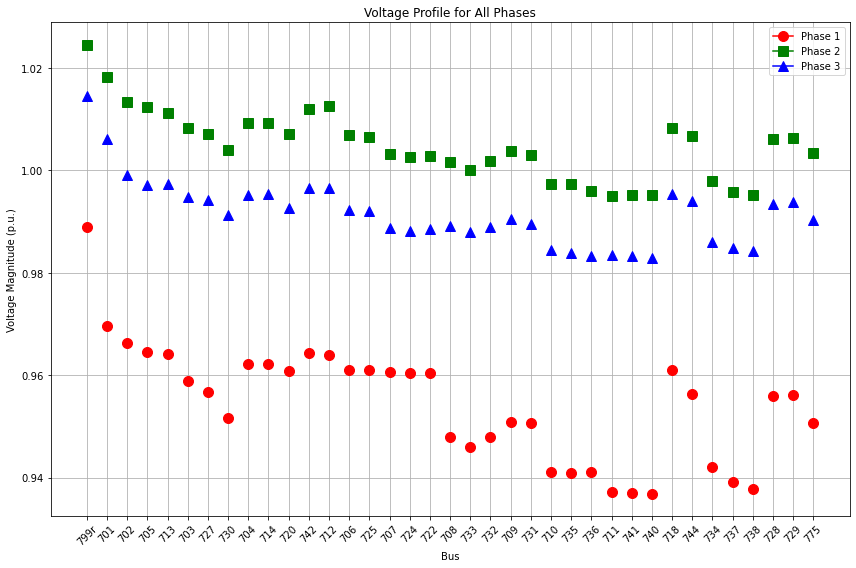

In [46]:
import pandas as pd
import numpy as np
from opendssdirect import dss
import os
import matplotlib.pyplot as plt
import json
import time
OPTIMIZATION_METHOD = "TNC"
class VoltageProfileSimulator:
    def __init__(self, test_case='37Bus', dss_master_file_path=None):
        self.test_case = test_case
        self.path = '/Users/babaktaheri/Desktop/OLDF/Multi-phase'
        if dss_master_file_path is None:
            #self.dss_master_file_path = f"/Users/babaktaheri/Desktop/OLDF/Multi-phase/data/IEEETestCases/{self.test_case}/IEEE13Nodeckt.dss"
            self.dss_master_file_path = f"/Users/babaktaheri/Desktop/OLDF/Multi-phase/data/IEEETestCases/{self.test_case}/ieee37.dss"
        else:
            self.dss_master_file_path = dss_master_file_path
        self.line_data = None
        self.buses = []
        self.phases = {'1', '2', '3'}
        self.bus_index = {}
        self.incidence_matrix = None
        self.incidence_df = None
        self.A = None
        self.F = None
        self.block_diagonal_matrix_hp = None
        self.block_diagonal_matrix_hq = None
        self.P_flat_pu_n_by_1 = None
        self.Q_flat_pu_n_by_1 = None
        self.reference_voltages = np.array([0.9890, 1.0245, 1.0146])  # IEEE 37 Bus
        #self.reference_voltages = np.array([1.056, 1.0374, 1.056]) #IEEE 13 Bus

    def load_dss_master_file(self):
        dss.run_command("Clear")
        dss.run_command(f'Redirect "{self.dss_master_file_path}"')
        if dss.Circuit.Name() == "":
            raise Exception("No active circuit. Please check the DSS master file.")

    @staticmethod
    def load_line_data_from_json(file_path):
        with open(file_path, 'r') as file:
            line_data = json.load(file)
        return line_data

    @staticmethod
    def extract_buses_and_phases(line_data):
        buses = []
        phases = {'1', '2', '3'}
        seen_buses = set()
        for line_info in line_data.values():
            bus1_base = line_info['FromBus'].split('.')[0]
            bus2_base = line_info['ToBus'].split('.')[0]
            if bus1_base not in seen_buses:
                buses.append(bus1_base)
                seen_buses.add(bus1_base)
            if bus2_base not in seen_buses:
                buses.append(bus2_base)
                seen_buses.add(bus2_base)
        bus_index = {bus: i for i, bus in enumerate(buses)}
        return buses, phases, bus_index

    @staticmethod
    def create_incidence_matrix(buses, phases, bus_index, line_data):
        incidence_matrix = np.zeros((len(buses) * len(phases), len(line_data) * len(phases)), dtype=int)
        for line_idx, (line_id, line_info) in enumerate(line_data.items()):
            bus1 = line_info['FromBus']
            bus2 = line_info['ToBus']
            bus1_phases = line_info['Bus1Phases']
            bus2_phases = line_info['Bus2Phases']
            for phase in phases:
                if phase in bus1_phases:
                    row_idx_bus1 = bus_index[bus1] * 3 + int(phase) - 1
                    incidence_matrix[row_idx_bus1, line_idx * 3 + int(phase) - 1] = 1
                if phase in bus2_phases:
                    row_idx_bus2 = bus_index[bus2] * 3 + int(phase) - 1
                    incidence_matrix[row_idx_bus2, line_idx * 3 + int(phase) - 1] = -1
        return incidence_matrix.T

    @staticmethod
    def prepare_incidence_df(incidence_matrix, buses, phases, line_data):
        incidence_df = pd.DataFrame(incidence_matrix, columns=[f"{bus}.{phase}" for bus in buses for phase in phases])
        incidence_df.index = [f"{line_name}.{phase}" for line_name in line_data.keys() for phase in phases]
        reference_bus = buses[0]
        reference_columns = [f"{reference_bus}.{phase}" for phase in phases]
        incidence_df.drop(columns=reference_columns, inplace=True)
        return incidence_df

    @staticmethod
    def compute_pseudo_inverse(incidence_df):
        A = incidence_df.to_numpy()
        F = np.linalg.pinv(A)
        return A, F

    def load_data_from_files(self):
        self.block_diagonal_matrix_hp = np.load(f'{self.path}/results/{self.test_case}_block_diagonal_matrix_hp.npy')
        self.block_diagonal_matrix_hq = np.load(f'{self.path}/results/{self.test_case}_block_diagonal_matrix_hq.npy')
        with open(f'{self.path}/results/{self.test_case}_P_base_pu.json', 'r') as f:
            P_data = json.load(f)
            self.P_flat_pu_n_by_1 = np.array([value for sublist in P_data.values() for value in sublist])
        with open(f'{self.path}/results/{self.test_case}_Q_base_pu.json', 'r') as f:
            Q_data = json.load(f)
            self.Q_flat_pu_n_by_1 = np.array([value for sublist in Q_data.values() for value in sublist])

    def calculate_voltage(self, H_p, H_q, rho, varrho, gamma):
        I = np.ones((len(self.A), 1))
        I = np.reshape(I, (len(self.A) // 3, 3))
        Ref_V = np.array([0.9890**2, 1.0245**2, 1.0146**2])  # IEEE 37 Bus
        I = I * Ref_V
        I = I.reshape(-1, 1)

        v = I - self.F @ H_p @ self.F.T @ ((-self.P_flat_pu_n_by_1.reshape(-1, 1)) + rho.reshape(-1, 1)) - self.F @ H_q @ self.F.T @ ((-self.Q_flat_pu_n_by_1.reshape(-1, 1)) + varrho.reshape(-1, 1)) + gamma.reshape(-1, 1)
        v = v**0.5
        P = self.A.T @ self.A
        B = np.zeros((len(self.A), 1))
        for i in range(len(self.A)):
            if np.any(P[i, :] != 0):
                B[i] = 1
        v = np.multiply(B, v)
        return v

    @staticmethod
    def initialize_voltage_matrix(v, bus_index, A, reference_voltages):
        V_matrix = np.ones((len(A) + 3, 1))
        ref_bus_idx = 0
        V_matrix[ref_bus_idx * 3:(ref_bus_idx + 1) * 3] = np.array(reference_voltages).reshape(-1, 1)
        start_idx = 0
        for bus, idx in bus_index.items():
            if idx > 0:
                V_matrix[idx * 3:(idx + 1) * 3] = v[start_idx:start_idx + 3].reshape(-1, 1)
                start_idx += 3
        return V_matrix

    @staticmethod
    def plot_voltage_profile(V_matrix, bus_index):
        plt.figure(figsize=(12, 8))
        bus_names = list(bus_index.keys())
        num_buses = len(bus_names)

        phase_info = {
            '1': {'color': 'r', 'marker': 'o'},
            '2': {'color': 'g', 'marker': 's'},
            '3': {'color': 'b', 'marker': '^'}
        }

        added_legend = set()

        for i, bus in enumerate(bus_names):
            for j, phase in enumerate(['1', '2', '3']):
                phase_index = i * 3 + j
                voltage = V_matrix[phase_index, 0]
                if voltage != 0:
                    label = f'Phase {phase}' if phase not in added_legend else ""
                    plt.plot(i, voltage, label=label, color=phase_info[phase]['color'], marker=phase_info[phase]['marker'], markersize=10)
                    if label:
                        added_legend.add(phase)

        plt.title('Voltage Profile for All Phases')
        plt.xlabel('Bus')
        plt.ylabel('Voltage Magnitude (p.u.)')
        plt.xticks(ticks=range(num_buses), labels=bus_names, rotation=45)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    def run(self):
        self.load_dss_master_file()
        self.line_data = self.load_line_data_from_json(f"{self.path}/results/{self.test_case}_line_data.json")
        self.buses, self.phases, self.bus_index = self.extract_buses_and_phases(self.line_data)
        self.incidence_matrix = self.create_incidence_matrix(self.buses, self.phases, self.bus_index, self.line_data)
        self.incidence_df = self.prepare_incidence_df(self.incidence_matrix, self.buses, self.phases, self.line_data)
        self.A, self.F = self.compute_pseudo_inverse(self.incidence_df)
        self.load_data_from_files()

        """Initial parameters"""
        H_p = self.block_diagonal_matrix_hp
        H_q = self.block_diagonal_matrix_hq
        rho = np.zeros(self.A.shape[0])
        varrho = np.zeros(self.A.shape[0])
        gamma = np.zeros(self.A.shape[0])

        """ Optimized parameters"""
        H_p     = np.loadtxt(f"{self.path}/parameters/H_p_{self.test_case}_{OPTIMIZATION_METHOD}.txt")
        H_q     = np.loadtxt(f"{self.path}/parameters/H_q_{self.test_case}_{OPTIMIZATION_METHOD}.txt")
        rho     = np.loadtxt(f"{self.path}/parameters/gamma_P_{self.test_case}_{OPTIMIZATION_METHOD}.txt")
        varrho  = np.loadtxt(f"{self.path}/parameters/gamma_Q_{self.test_case}_{OPTIMIZATION_METHOD}.txt")
        gamma   = np.loadtxt(f"{self.path}/parameters/bias_{self.test_case}_{OPTIMIZATION_METHOD}.txt")

        
        H_p    = H_p.reshape(A.shape[0], A.shape[0])
        H_q    = H_q.reshape(A.shape[0], A.shape[0])
        rho    = np.reshape(rho,(A.shape[0],))
        varrho = np.reshape(varrho,(A.shape[0],))
        gamma  = np.reshape(gamma,(A.shape[0],))

        start_time = time.process_time()
        v = self.calculate_voltage(H_p, H_q, rho, varrho, gamma)
        end_time = time.process_time()
        execution_time = end_time - start_time
        print(f'Total execution time: {execution_time} seconds')

        V_matrix = self.initialize_voltage_matrix(v, self.bus_index, self.A, self.reference_voltages)
        self.plot_voltage_profile(V_matrix, self.bus_index)

        np.savetxt(f"results/{self.test_case}_voltage_OLDF.csv", V_matrix, delimiter=",")


if __name__ == "__main__":
    simulator = VoltageProfileSimulator()
    simulator.run()


# AC3F

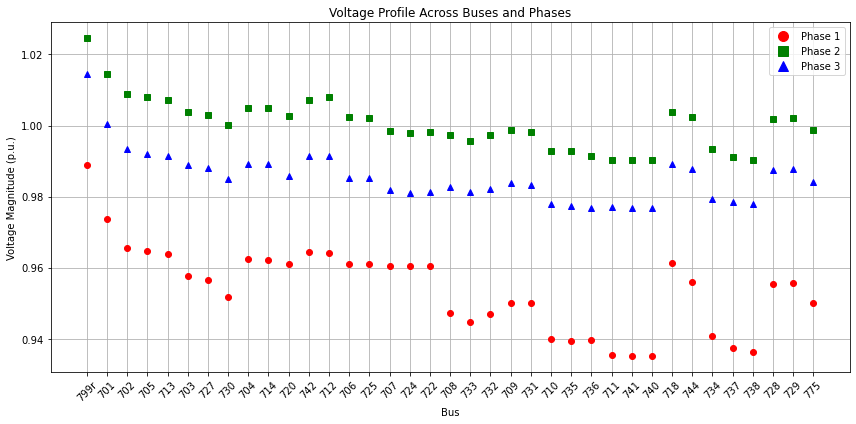

In [47]:
import json
import opendssdirect as dss
import matplotlib.pyplot as plt
import numpy as np

def load_line_data_from_json(file_path):
    with open(file_path, 'r') as file:
        line_data = json.load(file)
    return line_data

def extract_buses_and_phases(line_data):
    buses = []
    phases = {'1', '2', '3'}
    seen_buses = set()
    for line_info in line_data.values():
        bus1_base = line_info['FromBus'].split('.')[0]
        bus2_base = line_info['ToBus'].split('.')[0]
        if bus1_base not in seen_buses:
            buses.append(bus1_base)
            seen_buses.add(bus1_base)
        if bus2_base not in seen_buses:
            buses.append(bus2_base)
            seen_buses.add(bus2_base)
    bus_index = {bus: i for i, bus in enumerate(buses)}
    return buses, phases, bus_index

def get_bus_voltages(buses):
    bus_voltages = {bus: {'1': None, '2': None, '3': None} for bus in buses}
    for bus in buses:
        dss.Circuit.SetActiveBus(bus)
        vmag_angle = dss.Bus.puVmagAngle()
        nodes = dss.Bus.Nodes()
        for i, node in enumerate(nodes):
            phase = str(node)
            if phase in ['1', '2', '3']:
                index = 2 * i
                bus_voltages[bus][phase] = vmag_angle[index]
    return bus_voltages

def plot_voltages(bus_voltages):
    plt.figure(figsize=(12, 6))
    phase_styles = {'1': {'color': 'r', 'marker': 'o'}, '2': {'color': 'g', 'marker': 's'}, '3': {'color': 'b', 'marker': '^'}}
    bus_names = list(bus_voltages.keys())

    for i, bus in enumerate(bus_names):
        for phase, style in phase_styles.items():
            voltage = bus_voltages[bus][phase]
            if voltage:  # Only plot if there's a voltage
                plt.plot(i, voltage, style['marker'], color=style['color'],
                         label=f'Phase {phase}' if i == 0 else "")
    
    plt.xlabel('Bus')
    plt.ylabel('Voltage Magnitude (p.u.)')
    plt.title('Voltage Profile Across Buses and Phases')
    plt.xticks(ticks=range(len(bus_names)), labels=bus_names, rotation=45)
    plt.grid(True)
    handles = [plt.Line2D([0], [0], color=style['color'], marker=style['marker'], linestyle='', markersize=10, label=f'Phase {phase}') for phase, style in phase_styles.items()]
    plt.legend(handles=handles, loc='upper right')
    plt.tight_layout()
    plt.show()

def voltages_to_array(bus_voltages, buses, phases):
    num_buses = len(buses)
    num_phases = len(phases)
    voltage_array = np.zeros((num_buses * num_phases, 1))
    
    for i, bus in enumerate(buses):
        for j, phase in enumerate(sorted(phases)):
            voltage = bus_voltages[bus][phase]
            if voltage is not None:
                index = i * num_phases + j
                voltage_array[index, 0] = voltage
    
    return voltage_array

# Main execution block
if __name__ == "__main__":
    Test_Case = "37Bus"
    # Test_Case = "13Bus"

    dss_file_path = f"/Users/babaktaheri/Desktop/OLDF/Multi-phase/data/IEEETestCases/{Test_Case}/IEEE13Nodeckt.dss" if Test_Case == "13Bus" else f"/Users/babaktaheri/Desktop/OLDF/Multi-phase/data/IEEETestCases/{Test_Case}/ieee37.dss"
    dss.Command(f'Redirect "{dss_file_path}"')
    dss.Solution.Solve()

    line_data = load_line_data_from_json(f"/Users/babaktaheri/Desktop/OLDF/Multi-phase/results/{Test_Case}_line_data.json")
    buses, phases, bus_index = extract_buses_and_phases(line_data)
    bus_voltages = get_bus_voltages(buses)
    plot_voltages(bus_voltages)
    voltage_array = voltages_to_array(bus_voltages, buses, phases)

    np.savetxt(f"results/{Test_Case}_opendss_voltages.csv", voltage_array, delimiter=",")


# Compare AC3F and LinDist3Flow

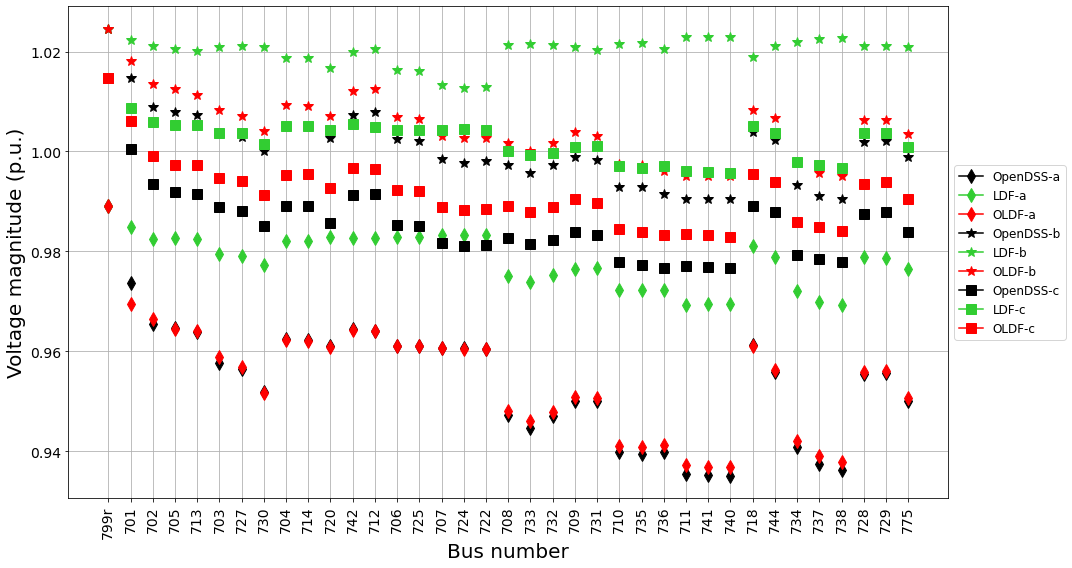

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import json
Test_case = "37Bus"
def load_line_data_from_json(file_path):
    """Load line data from a JSON file."""
    with open(file_path, 'r') as file:
        line_data = json.load(file)
    return line_data

def extract_buses_and_phases(line_data):
    """Extract bus names and phases from line data."""
    buses = []
    phases = {'a', 'b', 'c'}
    seen_buses = set()
    for line_info in line_data.values():
        bus1_base = line_info['FromBus'].split('.')[0]
        bus2_base = line_info['ToBus'].split('.')[0]
        if bus1_base not in seen_buses:
            buses.append(bus1_base)
            seen_buses.add(bus1_base)
        if bus2_base not in seen_buses:
            buses.append(bus2_base)
            seen_buses.add(bus2_base)
    bus_index = {bus: i for i, bus in enumerate(buses)}
    return buses, phases, bus_index

def plot_voltage_comparison(V_matrix1, V_matrix2, V_matrix3, bus_index, method_labels=['OpenDSS', 'LDF', 'OLDF'], output_file=f"Figs/{Test_case}_voltage_comparison.eps"):
    """Plot voltage comparison across buses and phases for multiple methods."""
    num_phases = 3  # Assuming three phases per bus
    plt.figure(figsize=(15, 8))
    bus_names = list(bus_index.keys())
    num_buses = len(bus_names)
    
    # Define colors and markers for each phase for all methods
    phase_info = {
        'a': {'colors': ['black', 'limegreen', 'red'], 'markers': ['d', 'd', 'd']},
        'b': {'colors': ['black', 'limegreen', 'red'], 'markers': ['*', '*', '*']},
        'c': {'colors': ['black', 'limegreen', 'red'], 'markers': ['s', 's', 's']}
    }
    
    added_legend = set()  # Track labels to avoid duplicate legend entries
    lines = []  # Store line objects for legend
    
    # Plot each phase for each bus from all methods
    for i, bus in enumerate(bus_names):
        for j, phase in enumerate(['a', 'b', 'c']):
            phase_index = bus_index[bus] * num_phases + j
            for k, V_matrix in enumerate([V_matrix1, V_matrix2, V_matrix3]):
                voltage = V_matrix[phase_index]
                if voltage != 0:  # Skip zero voltages
                    label = f'{method_labels[k]}-{phase}' if f'{method_labels[k]} {phase}' not in added_legend else ""
                    line, = plt.plot(i, voltage, label=label, color=phase_info[phase]['colors'][k], marker=phase_info[phase]['markers'][k], markersize=10)
                    if label:
                        added_legend.add(f'{method_labels[k]} {phase}')
                        lines.append(line)
                        
    plt.xlabel('Bus number', fontsize=20)
    plt.ylabel('Voltage magnitude (p.u.)', fontsize=20)
    plt.xticks(ticks=range(num_buses), labels=bus_names, rotation=90, fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True)
    
    # Create custom legend to maintain order
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)

    plt.tight_layout()
    plt.savefig(output_file, format='eps', bbox_inches='tight')  # Save the plot as EPS file
    plt.show()

if __name__ == "__main__":
    # Test_case = "13Bus"

    # Load voltage data
    V_matrix1 = np.loadtxt(f"results/{Test_case}_opendss_voltages.csv", delimiter=",")
    V_matrix2 = np.loadtxt(f"results/{Test_case}_voltage_LDF.csv", delimiter=",")
    V_matrix3 = np.loadtxt(f"results/{Test_case}_voltage_OLDF.csv", delimiter=",")  # Load the third set of voltage data

    # Load line data from JSON file and extract necessary data
    line_data = load_line_data_from_json(f"/Users/babaktaheri/Desktop/OLDF/Multi-phase/results/{Test_case}_line_data.json")
    buses, phases, bus_index = extract_buses_and_phases(line_data)

    # Call the function to plot the voltage comparison and save it as EPS
    plot_voltage_comparison(V_matrix1, V_matrix2, V_matrix3, bus_index, output_file=f"Figs/{Test_case}_voltage_comparison.eps")


In [49]:
AVG_LDF = (1/len(V_matrix2))*np.linalg.norm(V_matrix2-V_matrix1, 1)
MAX_LDF = np.linalg.norm(V_matrix2-V_matrix1, np.inf)
print(f'Avg error for LDF{TEST_CASE} Bus: ',AVG_LDF)
print(f'Max  Error for LDF: {MAX_LDF}')

AVG_OLDF = (1/(len(V_matrix2)))*np.linalg.norm(V_matrix3-V_matrix1, 1)
MAX_OLDF = np.linalg.norm(V_matrix3-V_matrix1, np.inf)
print(f'Avg error for OLDF{TEST_CASE} Bus: ',AVG_OLDF)
print(f'Max  Error for OLDF: {MAX_OLDF}')

Avg error for LDF37Bus Bus:  0.020226975918991082
Max  Error for LDF: 0.03434792650744256
Avg error for OLDF37Bus Bus:  0.0037588433734111622
Max  Error for OLDF: 0.0071057763322383005
